In [11]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [12]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

In [13]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

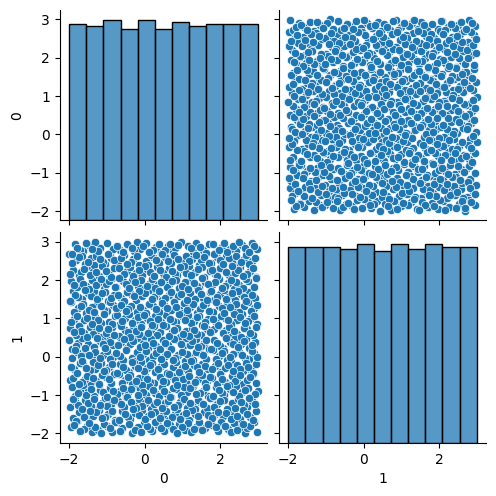

In [14]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [15]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function

coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.1)
dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

TypeError: BraninFunction() got an unexpected keyword argument 'loop'

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [ ]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [7]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = coexbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)
results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 0.000e+00


AttributeError: 'SingleTaskGP' object has no attribute 'train_X'

# Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [ ]:
results

tensor([[18.3568,  4.5599,  9.8314,  0.6188],
        [19.2872,  4.6707,  8.8585,  0.6127],
        [ 8.6697,  4.9159,  8.9054,  0.6068],
        [ 7.9952,  4.9791,  8.0723,  0.6010],
        [19.1878,  5.0256,  8.5858,  0.6048],
        [ 7.9986,  5.0351,  8.5399,  0.6085],
        [19.0701,  5.0351,  8.5371,  0.6121],
        [ 7.5263,  5.0359,  8.5306,  0.6157],
        [16.6228,  5.0367,  8.5164,  0.6193],
        [10.5230,  5.0367,  8.5291,  0.6227]])